In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

In [2]:
df = pd.read_csv("../data/processed/kddcup_data_processed.csv")
X = df.drop(columns=["attack_type"])
y = df["attack_type"]

In [3]:
df.shape, X.shape, y.shape

((494021, 32), (494021, 31), (494021,))

## Oversampling

In [5]:
y.value_counts()

attack_type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE only to the 'u2r' category
smote = SMOTE(sampling_strategy={'u2r': 1000})
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the oversampled 'u2r' instances with the original dataset
X_combined = pd.concat([X, pd.DataFrame(X_resampled[len(X):], columns=X.columns)])
y_combined = pd.concat([y, pd.Series(y_resampled[len(y):])])

# shuffling the data
combined_df = pd.concat([X_combined, y_combined], axis=1)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Check the class distribution after oversampling
y_combined.value_counts()

attack_type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r         1000
Name: count, dtype: int64

---

In [9]:
X, y = combined_df.drop(columns=["attack_type"]), combined_df["attack_type"]
X_scaled = scaler.fit_transform(X)

In [31]:
y.value_counts()

attack_type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r         1000
Name: count, dtype: int64

In [10]:
import numpy as np
import plotly.express as px

indices = []
np.random.seed(42)

for attack_type in y.unique():
    print(attack_type, y[y == attack_type].shape[0])
    if y[y == attack_type].shape[0] < 5000:
        print(f"attack_type: {attack_type} has less than 5000 samples -> using all samples")
        indices.extend(y[y == attack_type].index)
    else:
        indices.extend(np.random.choice(y[y == attack_type].index, 5000, replace=False, ))

# or just use df.col.sample(5000, frac=1) to shuffle the data

X_reduced = X_scaled[indices]
y_reduced = y[indices]

# sanity check
px.bar(x=y[indices].value_counts().index,
       y=y[indices].value_counts().values)

dos 391458
normal 97278
u2r 1000
attack_type: u2r has less than 5000 samples -> using all samples
probe 4107
attack_type: probe has less than 5000 samples -> using all samples
r2l 1126
attack_type: r2l has less than 5000 samples -> using all samples


In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(X_reduced)

In [41]:
fig = px.scatter(x=tsne_features[:, 0], y=tsne_features[:, 1], color=y_reduced, title="t-SNE Algorithm with oversampling", labels={"x": "x: t-SNE 1", "y": "y: t-SNE 2"}, template="plotly_dark",
                 color_discrete_map={
                     "normal": "#636EFA", 
                     "u2r": "#EF553B", 
                     "dos": "#00CC96", 
                     "r2l": "#AB63FA",
                     "probe": "#FFA15A"})  # specify the color for each category)
fig.update_traces(marker=dict(size=4))
fig.write_html("../figures/html_figs/tsne_dark_oversmampled.html")
fig

---

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

print(classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

         dos       1.00      1.00      1.00     78292
      normal       1.00      1.00      1.00     19456
       probe       1.00      0.99      1.00       821
         r2l       1.00      0.98      0.99       225
         u2r       0.99      1.00      1.00       200

    accuracy                           1.00     98994
   macro avg       1.00      0.99      1.00     98994
weighted avg       1.00      1.00      1.00     98994



In [15]:
f1_score(y_test, rf_clf.predict(X_test), average='weighted')

0.9998279575226776

In [16]:
from sklearn.metrics import confusion_matrix

y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[78288     4     0     0     0]
 [    1 19454     0     1     0]
 [    1     5   815     0     0]
 [    0     3     0   220     2]
 [    0     0     0     0   200]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cm(y_true, y_pred, figsize=(10,10)):   
        
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.3f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.3f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

/var/folders/15/wc5q4q7x74s558bh7r8mp75c0000gn/T/ipykernel_25589/4082643656.py:19: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



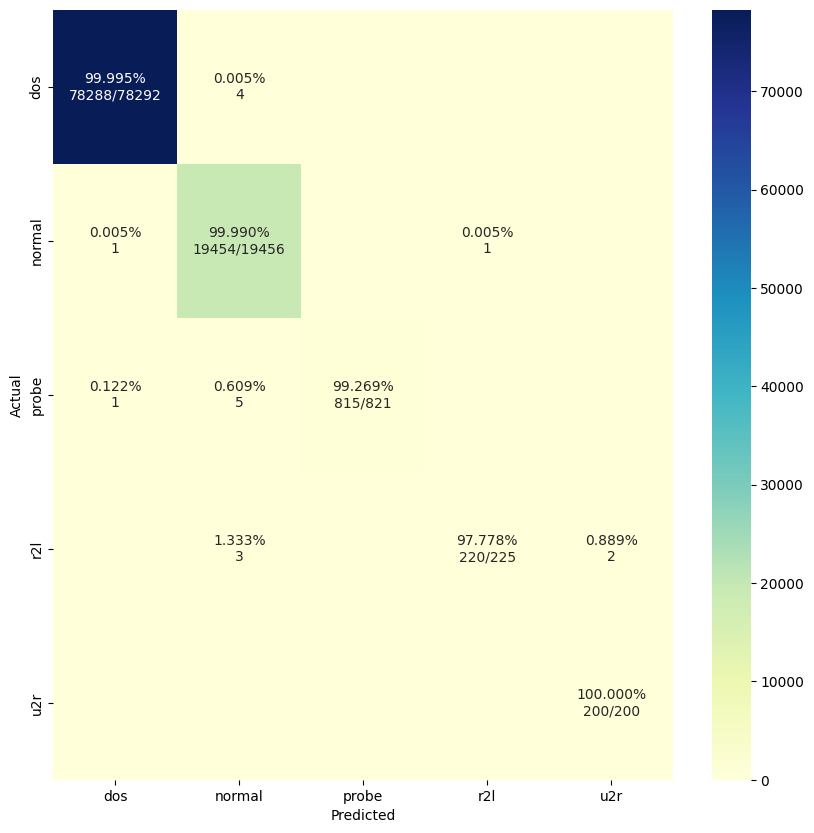

In [18]:
plot_cm(y_test, y_pred)

In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(rf_clf, X_scaled, y, cv=5, scoring='f1_weighted')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)


Cross-Validation Scores: [0.99977763 0.99986864 0.99985841 0.9997358  0.99974664]


---